In [33]:
import antiCPy
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import LeakyReLU
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [34]:
XAI = np.load("XAI_Finance.npy")
Names = np.load("Names.npy")
CorrMatrices = np.load("CorrMatricesTriangular.npy")
LabelNaiveOrdered = np.load("LabelNaiveOrdered.npy")
OptimalXAI = np.load("OptimalXAIFeature.npy")

In [35]:
clf = RandomForestClassifier(max_depth=20, random_state=0)

In [36]:
# 1 vs. all other clusters
print(OptimalXAI[0,:])

Label0 = (LabelNaiveOrdered == OptimalXAI[0,0])*1
print(Label0)

Data_0opt = CorrMatrices[:,OptimalXAI[0,1]]
Data_0opt = Data_0opt.reshape(-1,1)

# transform the imbalanced Data set
oversample = SMOTE()
Data_0opt, Label0 = oversample.fit_resample(Data_0opt, Label0)

X_train, X_test, y_train, y_test = train_test_split(Data_0opt, Label0,
                                                    test_size=0.5, random_state=1)
#X_train, y_train = oversample.fit_resample(X_train, y_train)

print(X_train.mean(), X_test.mean(), y_train.mean(), y_test.mean())

[0 4]
[1 1 0 ... 0 0 0]
0.39942958827334196 0.39664028262655504 0.5062355658198614 0.49376443418013855


In [37]:
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)
print(np.mean(y_hat))
np.mean(y_hat == y_test )

0.5367205542725173


0.6678983833718245

Optimal feature is 4


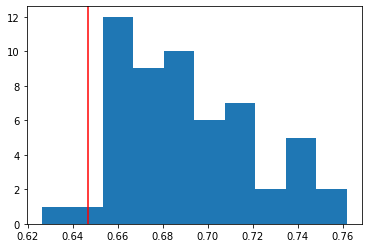

Optimal feature is 21


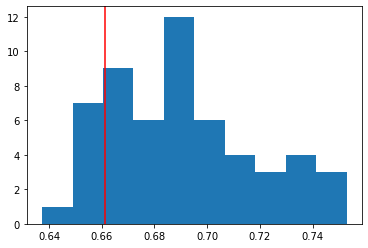

Optimal feature is 11


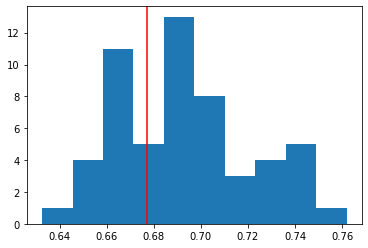

Optimal feature is 2


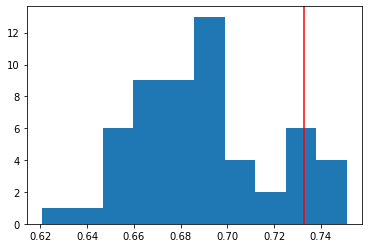

Optimal feature is 3


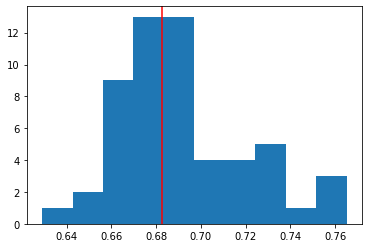

Optimal feature is 2


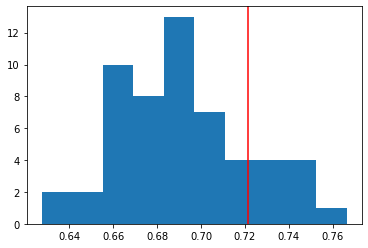

Optimal feature is 15


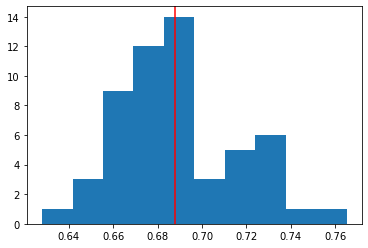

Optimal feature is 4


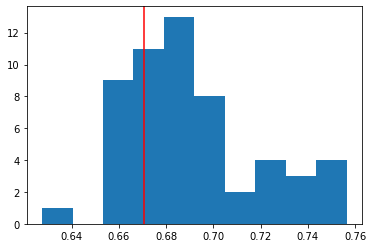

In [38]:
oversample = SMOTE()
for j in range(OptimalXAI.shape[0]):
    Scores = list()
    print("Optimal feature is", OptimalXAI[j,1])
    for i in range(CorrMatrices.shape[1]):
        Label0 = (LabelNaiveOrdered == OptimalXAI[0,0])*1
        Data_0 = CorrMatrices[:,i].reshape(-1,1)
        Data_0, Label0 = oversample.fit_resample(Data_0, Label0)
        X_train, X_test, y_train, y_test = train_test_split(Data_0, Label0,
                                                    test_size=0.5, random_state=1)
        clf.fit(X_train, y_train)
        y_hat = clf.predict(X_test)
        Scores.append( np.mean(y_hat == y_test ))
    plt.hist(Scores)
    plt.axvline(Scores[OptimalXAI[j,1]],c="red")
    plt.show()

### Train NN with all relevant features

For this, we need one-hot encoded y

In [47]:
print(set(OptimalXAI[:,1]))
CM_Reduced = CorrMatrices[:,list(set(OptimalXAI[:,1]))]
print(CM_Reduced.shape)

# one hot encoded
encoded_Y = np_utils.to_categorical(LabelNaiveOrdered)

X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
print(encoded_Y)

# reverse the encoding via
# np.argmax(encoded_Y, 1)

{2, 3, 4, 11, 15, 21}
(5251, 6)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


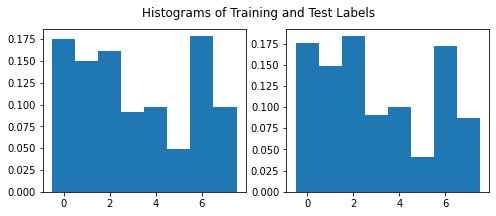

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(np.argmax(y_train,1), density = True,
         bins = np.arange(-0.5, max(np.argmax(y_train,1))+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Training and Test Labels")
plt.show()

In [49]:
n_In = CM_Reduced.shape[1]
num_classes = len(set(LabelNaiveOrdered))
print(n_In, num_classes)

model = keras.Sequential(
    [
        layers.Dense(units = 256, input_shape=(n_In,), activation = "selu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=128, activation="relu"),
        layers.Dense(units=1024,
              activation=keras.layers.LeakyReLU(alpha=0.05)),
        layers.Dense(units=128,
              activation=keras.layers.LeakyReLU(alpha=0.01)),
        layers.Dropout(0.3),
        layers.Dense(units =num_classes, activation="softmax"),
    ]
)
#model.build(n_In)
model.summary()

6 8
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 256)               1792      
                                                                 
 dense_31 (Dense)            (None, 128)               32896     
                                                                 
 dense_32 (Dense)            (None, 128)               16512     
                                                                 
 dense_33 (Dense)            (None, 1024)              132096    
                                                                 
 dense_34 (Dense)            (None, 128)               131200    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 8)            

In [50]:
batch_size = 128
epochs = 100

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5)

Epoch 1/100
14/14 [==============================] - 1s 17ms/step - loss: 2.0343 - accuracy: 0.1922 - val_loss: 2.0019 - val_accuracy: 0.1717
Epoch 2/100
14/14 [==============================] - 0s 8ms/step - loss: 1.9685 - accuracy: 0.1853 - val_loss: 1.9425 - val_accuracy: 0.1717
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 1.9121 - accuracy: 0.2024 - val_loss: 1.8836 - val_accuracy: 0.2058
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 1.8484 - accuracy: 0.2581 - val_loss: 1.8110 - val_accuracy: 0.2683
Epoch 5/100
14/14 [==============================] - 0s 6ms/step - loss: 1.7654 - accuracy: 0.3223 - val_loss: 1.7157 - val_accuracy: 0.3434
Epoch 6/100
14/14 [==============================] - 0s 6ms/step - loss: 1.6700 - accuracy: 0.3513 - val_loss: 1.6122 - val_accuracy: 0.3553
Epoch 7/100
14/14 [==============================] - 0s 6ms/step - loss: 1.5809 - accuracy: 0.3724 - val_loss: 1.5228 - val_accuracy: 0.3803
Epoch 8/100


In [51]:
y_hat = np.argmax(model.predict(X_test),1)
Accuracy_BestXAI = np.mean(y_hat == np.argmax(y_test,1))
print(Accuracy_BestXAI)

0.7178303519907675


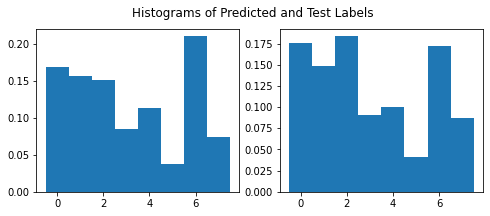

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(8, 3)
ax1.hist(y_hat, density = True,
         bins = np.arange(-0.5, max(y_hat)+1.5,1))
ax2.hist(np.argmax(y_test,1),density = True,
         bins = np.arange(-0.5, max(np.argmax(y_test,1))+1.5,1))
plt.suptitle("Histograms of Predicted and Test Labels")
plt.show()

### Now with some other features

In [45]:
def TestNN(seed = 1234):
    np.random.seed(seed)
    Index = np.random.choice(np.arange(XAI.shape[1]).astype("int"), # features to compare optimal XAI to
                     size = len(list(set(OptimalXAI[:,1]))),
                     replace = False)
    CM_Reduced = CorrMatrices[:,Index]
    X_train, X_test, y_train, y_test = train_test_split(CM_Reduced, encoded_Y,
                                                    test_size=0.33, random_state=1)
    model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.5,
          verbose=0)
    y_hat = np.argmax(model.predict(X_test),1)
    return(np.mean(y_hat == np.argmax(y_test,1)))

In [53]:
TestNN(54321)

0.7963069821119446

In [54]:
TestNN()

0.760530871321408

In [60]:
Runs = 20
NN_comparison = np.zeros(Runs)

for i in range(Runs):
    s = np.random.choice(np.arange(10000).astype("int"),1)
    Test_Score = TestNN(s)
    print(i,s,Test_Score)
    NN_comparison[i] = Test_Score


0 [4377] 0.8563185227928448
1 [442] 0.742065781881131
2 [8915] 0.7882285054818234
3 [7070] 0.8245816503173687
4 [1859] 0.86266589728794
5 [6024] 0.6912867859203693
6 [7635] 0.8141950375072129
7 [1448] 0.8493941142527409
8 [6978] 0.8343912290825158
9 [367] 0.8280438545874207
10 [7837] 0.778995960761685
11 [8408] 0.8390075014425851
12 [4231] 0.8384304673975764
13 [7605] 0.7928447778418927
14 [3449] 0.8453548759376803
15 [849] 0.8193883439122909
16 [5402] 0.8672821696480092
17 [3134] 0.8026543566070398
18 [2893] 0.8603577611079054
19 [3775] 0.8107328332371609


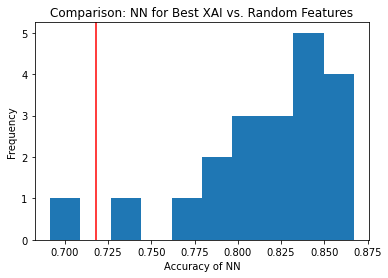

In [64]:
plt.hist(NN_comparison)
plt.axvline(Accuracy_BestXAI,
            c="red")
plt.xlabel("Accuracy of NN")
plt.ylabel("Frequency")
plt.title("Comparison: NN for Best XAI vs. Random Features")
plt.show()